# Importing

Libraries

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import cv2
import numpy as np
import easyocr
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import os


# TOOL

Class tool for OCR

Tesseract

In [ ]:
# import pytesseract

# # Nếu dùng Windows, set path nếu cần
# class Processing:
#     def __init__(self, num_threads=4, gpu = False):
#         # For task detect
#         pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
#         self.paddle_reader = PaddleOCR(lang='en', show_log=False,use_gpu = gpu)
#         # For run many task simultaneously (don't test this function, it is not complete) 
#         self.num_threads = num_threads
    
#     def rec(self, image):
#         # OCR tiếng Việt
#         text = pytesseract.image_to_string(image, lang='vie')
#         return text
    
#     def find_rects_texts(self, img_path, mode_draw= 0):
#         '''Function for find rects (bounding box) and text respectively'''
#         image = cv2.imread(img_path)
#         if image is None:
#             raise FileNotFoundError(f"Cannot read image at path: {img_path}")
#         img = image.copy()
#         a = 10
#         b = a / 1.5
#         h, w = image.shape[:2]
#         image_resized = cv2.resize(image, (int(w * a), int(h * b)))
#         result = self.paddle_reader.ocr(image_resized, cls=True, rec= False)[0][::-1]

#         rects, horizontal_list, texts = [], [], []

#         padding = 6
#         for line in result:
#             box = np.array(line, dtype=np.float32)
#             x, y, w, h = cv2.boundingRect(box)
#             x1, y1 = max(int(int(x / a) - padding), 0), max(int(int(y / b) - padding), 0)
#             x2, y2 = int(int((x + w) / a) + padding), int(int((y + h) / b) + padding)

#             rects.append([x1, y1, x2, y2])
#             img_cut = img[y1:y2, x1:x2]
#             text = self.rec(img_cut).strip()
#             texts.append(text)
#             # horizontal_list.append([x1, x2, y1, y2])

#         rects = np.array(rects, dtype=int)

#         if mode_draw:
#             for rect in rects:
#                 cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 1)
#             plt.figure(figsize=(12, 12))
#             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#             plt.axis('off')
#             plt.show()

#         return rects, texts

#     def check_line(self, box1, box2):
#         '''Check two bounding are all on a line'''
#         return abs((box1[1] + box1[3]) // 2 - (box2[1] + box2[3]) // 2) < 10

#     def rects_texts_ncollum_processed(self, rects, texts):
#         rects_new, txts_new = [], []
#         current_rect, current_txt = [], []
#         max_col = 0

#         for i, text in enumerate(texts):
#             text = text.strip()
#             if not text: 
#                 continue
#             if text[0].isdigit() and text[-1].isdigit():
#                 text = text.replace(',', '.')

#             if not current_rect or self.check_line(current_rect[-1], rects[i]):
#                 current_rect.append(rects[i])
#                 current_txt.append(text)
#             else:
#                 combined = sorted(zip(current_rect, current_txt), key=lambda x: (x[0][0] + x[0][2]) // 2)
#                 cur_rect_sorted, cur_txt_sorted = zip(*combined)
#                 rects_new.append(np.array(cur_rect_sorted))
#                 txts_new.append(list(cur_txt_sorted))
#                 max_col = max(max_col, len(cur_txt_sorted))
#                 current_rect = [rects[i]]
#                 current_txt = [text]

#         if current_rect:
#             combined = sorted(zip(current_rect, current_txt), key=lambda x: (x[0][0] + x[0][2]) // 2)
#             cur_rect_sorted, cur_txt_sorted = zip(*combined)
#             rects_new.append(np.array(cur_rect_sorted))
#             txts_new.append(list(cur_txt_sorted))
#             max_col = max(max_col, len(cur_txt_sorted))

#         return rects_new, txts_new, max_col

#     def find_box_cols(self, rects_box, n_cols):
#         cols_data = [row[:, [0, 2]].flatten() for row in rects_box if len(row) == n_cols]
#         cols_data = np.array(cols_data)

#         col_xmin = cols_data[:, ::2].min(axis=0)
#         col_xmax = cols_data[:, 1::2].max(axis=0)

#         return np.stack((col_xmin, col_xmax), axis=1)

#     def find_text_each_row(self, box_cols, list_rects, list_texts):
#         result = []
#         for row_rects, row_texts in zip(list_rects, list_texts):
#             row_data = [''] * len(box_cols)
#             for rect, text in zip(row_rects, row_texts):
#                 x_center = (rect[0] + rect[2]) // 2
#                 for idx, (xmin, xmax) in enumerate(box_cols):
#                     if xmin <= x_center <= xmax:
#                         row_data[idx] = (row_data[idx] + ' ' + text).strip() if row_data[idx] else text
#                         break
#             result.append(row_data)
#         return result

#     def process_single_image(self, img_path, draw=0):
#         rects, texts = self.find_rects_texts(img_path, draw)
#         rects_grouped, texts_grouped, n_cols = self.rects_texts_ncollum_processed(rects, texts)
#         box_cols = self.find_box_cols(rects_grouped, n_cols)
#         return self.find_text_each_row(box_cols, rects_grouped, texts_grouped)

#     def processing(self, img_paths):
#         if isinstance(img_paths, str):
#             img_paths = [img_paths]

#         results_all = []

#         with ThreadPoolExecutor(max_workers=self.num_threads) as executor:
#             futures = {
#                 executor.submit(self.process_single_image, path, draw = 0): path
#                 for path in img_paths
#             }

#             for future in as_completed(futures):
#                 img_path = futures[future]
#                 try:
#                     result = future.result()
#                     results_all.append(result)

#                     # Nếu bật chế độ xuất CSV
#                     df = pd.DataFrame(result)
#                     out_file = os.path.splitext(img_path)[0] + '.csv'
#                     df.to_csv(out_file, index=False, header=False)
#                     print(f"✅ Output CSV saved to: {out_file}")

#                 except Exception as e:
#                     print(f"❌ Error processing {img_path}: {e}")
        
#         return results_all

In [2]:
class Processing:
    def __init__(self, num_threads=4, gpu = False):
        # For task recogineze
        self.reader = easyocr.Reader(['vi', 'en'], verbose=False, gpu= gpu)
        # For task detect
        self.paddle_reader = PaddleOCR(lang='en', show_log=False,use_gpu = gpu)
        # For run many task simultaneously (don't test this function, it is not complete) 
        self.num_threads = num_threads

    def find_rects_texts(self, img_path, mode_draw= 0):
        '''Function for find rects (bounding box) and text respectively'''
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Cannot read image at path: {img_path}")
        img = image.copy()
        a = 10
        b = a / 1.5
        h, w = image.shape[:2]
        image_resized = cv2.resize(image, (int(w * a), int(h * b)))
        result = self.paddle_reader.ocr(image_resized, cls=True, rec= False)[0][::-1]

        rects, horizontal_list, texts = [], [], []

        padding = 2
        for line in result:
            box = np.array(line, dtype=np.float32)
            x, y, w, h = cv2.boundingRect(box)
            x1, y1 = max(int(int(x / a) - padding), 0), max(int(int(y / b) - padding), 0)
            x2, y2 = int(int((x + w) / a) + padding), int(int((y + h) / b) + padding)

            rects.append([x1, y1, x2, y2])
            horizontal_list.append([x1, x2, y1, y2])

        rects = np.array(rects, dtype=int)
        results = self.reader.recognize(img, horizontal_list=horizontal_list, free_list=[])

        for _, text, _ in results:
            text = text.strip()
            if text == '1.': text = 'I.'
            elif text == '11.': text = 'II.'
            elif len(text) >= 2 and text[0] == '[' and text[-1].isdigit():
                text = '1'+ text[1:]
            else:
                chars = list(text)
                for i in range(1, len(chars)):
                    if chars[i] == '1' and chars[i - 1] == 'I':
                        chars[i] = 'I'
                text = ''.join(chars)
            texts.append(text)

        if mode_draw:
            for rect in rects:
                cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 1)
            plt.figure(figsize=(12, 12))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        return rects, texts

    def check_line(self, box1, box2):
        '''Check two bounding are all on a line'''
        return abs((box1[1] + box1[3]) // 2 - (box2[1] + box2[3]) // 2) < 10

    def rects_texts_ncollum_processed(self, rects, texts):
        rects_new, txts_new = [], []
        current_rect, current_txt = [], []
        max_col = 0

        for i, text in enumerate(texts):
            text = text.strip()
            if not text: 
                continue
            if text[0].isdigit() and text[-1].isdigit():
                text = text.replace(',', '.')

            if not current_rect or self.check_line(current_rect[-1], rects[i]):
                current_rect.append(rects[i])
                current_txt.append(text)
            else:
                combined = sorted(zip(current_rect, current_txt), key=lambda x: (x[0][0] + x[0][2]) // 2)
                cur_rect_sorted, cur_txt_sorted = zip(*combined)
                rects_new.append(np.array(cur_rect_sorted))
                txts_new.append(list(cur_txt_sorted))
                max_col = max(max_col, len(cur_txt_sorted))
                current_rect = [rects[i]]
                current_txt = [text]

        if current_rect:
            combined = sorted(zip(current_rect, current_txt), key=lambda x: (x[0][0] + x[0][2]) // 2)
            cur_rect_sorted, cur_txt_sorted = zip(*combined)
            rects_new.append(np.array(cur_rect_sorted))
            txts_new.append(list(cur_txt_sorted))
            max_col = max(max_col, len(cur_txt_sorted))

        return rects_new, txts_new, max_col

    def find_box_cols(self, rects_box, n_cols):
        cols_data = [row[:, [0, 2]].flatten() for row in rects_box if len(row) == n_cols]
        cols_data = np.array(cols_data)

        col_xmin = cols_data[:, ::2].min(axis=0)
        col_xmax = cols_data[:, 1::2].max(axis=0)

        return np.stack((col_xmin, col_xmax), axis=1)

    def find_text_each_row(self, box_cols, list_rects, list_texts):
        result = []
        for row_rects, row_texts in zip(list_rects, list_texts):
            row_data = [''] * len(box_cols)
            for rect, text in zip(row_rects, row_texts):
                x_center = (rect[0] + rect[2]) // 2
                for idx, (xmin, xmax) in enumerate(box_cols):
                    if xmin <= x_center <= xmax:
                        row_data[idx] = (row_data[idx] + ' ' + text).strip() if row_data[idx] else text
                        break
            result.append(row_data)
        return result

    def process_single_image(self, img_path, draw=0):
        rects, texts = self.find_rects_texts(img_path, draw)
        rects_grouped, texts_grouped, n_cols = self.rects_texts_ncollum_processed(rects, texts)
        box_cols = self.find_box_cols(rects_grouped, n_cols)
        return self.find_text_each_row(box_cols, rects_grouped, texts_grouped)

    def processing(self, img_paths):
        if isinstance(img_paths, str):
            img_paths = [img_paths]

        results_all = []

        with ThreadPoolExecutor(max_workers=self.num_threads) as executor:
            futures = {
                executor.submit(self.process_single_image, path, draw = 0): path
                for path in img_paths
            }

            for future in as_completed(futures):
                img_path = futures[future]
                try:
                    result = future.result()
                    results_all.append(result)

                    # Nếu bật chế độ xuất CSV
                    df = pd.DataFrame(result)
                    out_file = os.path.splitext(img_path)[0] + '.csv'
                    df.to_csv(out_file, index=False, header=False)
                    print(f"✅ Output CSV saved to: {out_file}")

                except Exception as e:
                    print(f"❌ Error processing {img_path}: {e}")
        
        return results_all

Init tool (should put this line in one cell for more many tasks OCR)

In [3]:
tool = Processing(gpu= False)

Run task OCR

[2025/04/17 16:23:45] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


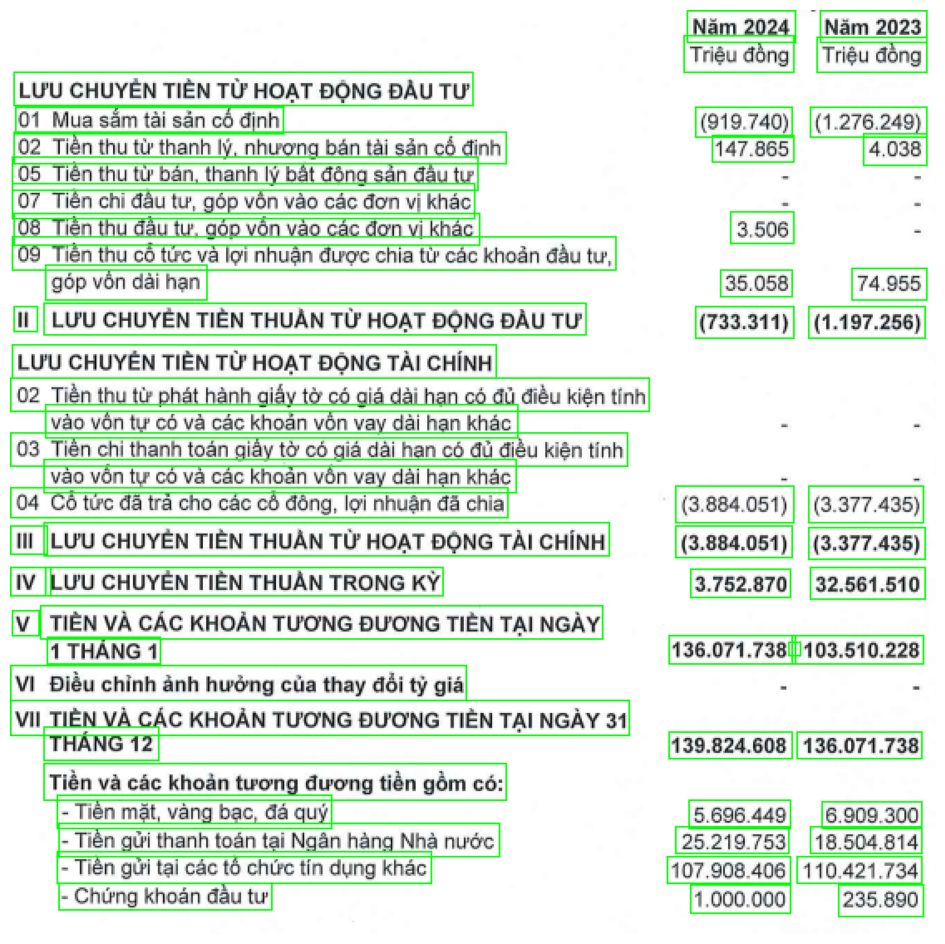

      0                                                  1            2  \
0                                                              Năm 2024   
1                                                            Triệu đồng   
2                     LƯU CHUYEN TIỀN TỪ HOẠT ĐỘNG ĐAU TU'                
3                               01 Mua sám tàỉ sản có đjnh    (919.740)   
4        02   Tièn thu tử thanh lý, nhượng bán tài sản ...      147.865   
5         05 Tiền thu từ bán; thanh lý bất động sản đàu tư                
6          07 Tiên chi đầu tư, góp vốn vào các đơn vỉ khác                
7         08  Tièn thu đằu tư, góp vốn vào các đơn vị khảc        3.506   
8        09 Tièn thu có tức và lợi nhuận được chia tử c...                
9                                          góp vốn dài hạn       35.058   
10   II          LƯU CHUYEN TIỀN THUAN TỬ HOẠT ĐỌNG ĐẢU TU    (733.311)   
11                  LƯU CHUYỂN TIỀN TỪ HOẠT ĐỌNG TÀl CHÍNH                
12       02 Tỉền thu từ p

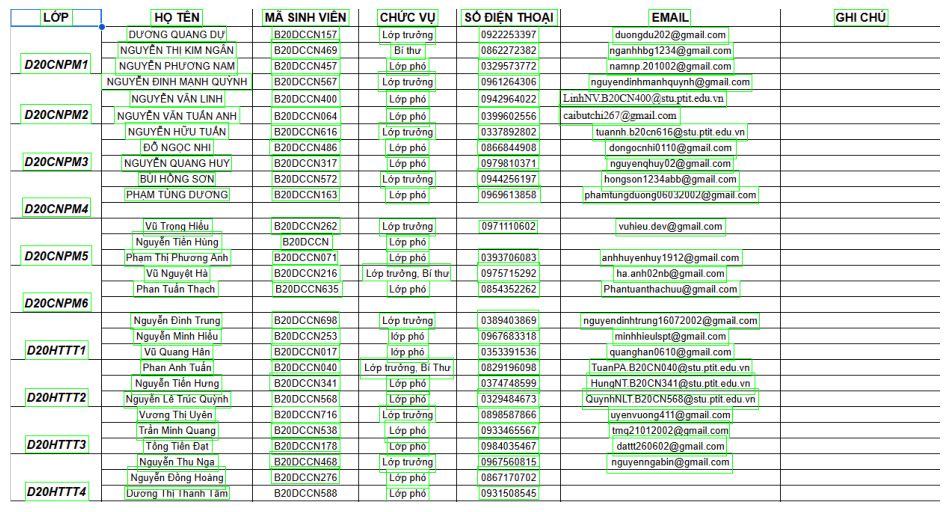

           0                        1             2                   3  \
0        LớP                   Họ TÊN  MÃ SINH VIÊN             CHỨC VỤ   
1                      DƯƠNG QUANG DỰ    BZODCCN157          Lớp_trưởng   
2                 NGUYẾN THỊ KIM NGÂN    B2ODCCN469              Bí thư   
3   D2OCNPMI        NGUYEN PHUONG NAM    BZODCCN45Z             LớP_phó   
4             [NGUYEN ĐINH MANH QUỲNH    BZODCCN567          Lớp truởng   
5                     NGUYỄN VĂN LINH    BZODCCN4OO             LớP_phó   
6   D2OCNPM2      NGUYỄN VĂN TUAN ANH    BZODCCNO64             Lớp phó   
7                     NGUYỄN HỮU TUAN   BZODCCNG 16          Lớp trường   
8                         ĐỖ NGỌC NHI    BZODCCN486             Lớp phỏ   
9   D2OCNPM3         NGUYEN QUANG HUY    BZODCCN317             Lớp phó   
10                       BÙl HỒNG SƠN    BZODCCN572          Lớp_trưởng   
11                    PHẠM TÙNG DUƠNG    BZODCCN163             Lớp_phó   
12  D2OCNPM4             

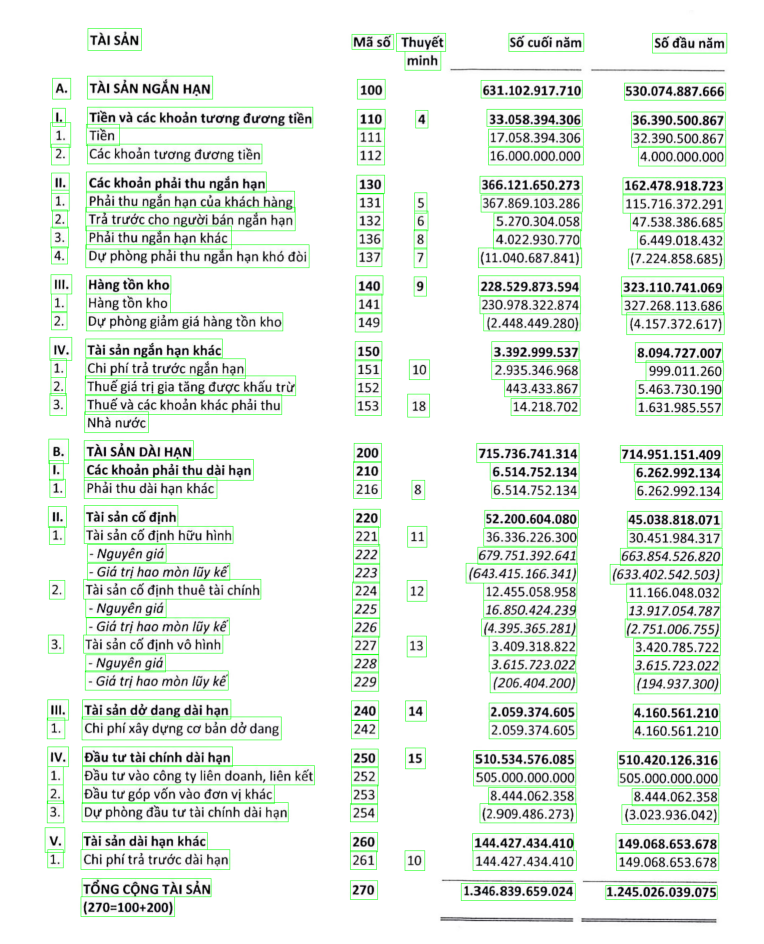

       0                                        1      2       3  \
0                                         TÀI SẢN  Mã số  Thuyết   
1                                                           minh   
2     A.                         TÀI SẢN NGẮN HẠN    100           
3      1       Tiền và các khoản tương đương tiền    110       4   
4     I.                                     Tiền    111           
5      2               Các khoản tương đương tiền    112           
6     I.              Các khoản phải thu ngắn hạn    130           
7     I.         Phải thu ngắn hạn của khách hàng    131       5   
8      2         Trả trước cho người bán ngắn hạn    132       6   
9     3.                   Phải thu ngắn hạn khác    136       8   
10    4.       Dự phòng phải thu ngắn hạn khó đòi    137       7   
11   III                             Hàng tồn kho    140       9   
12    I.                             Hàng tồn kho    141           
13    2.           Dự phòng giảm giá hàng tồn kh

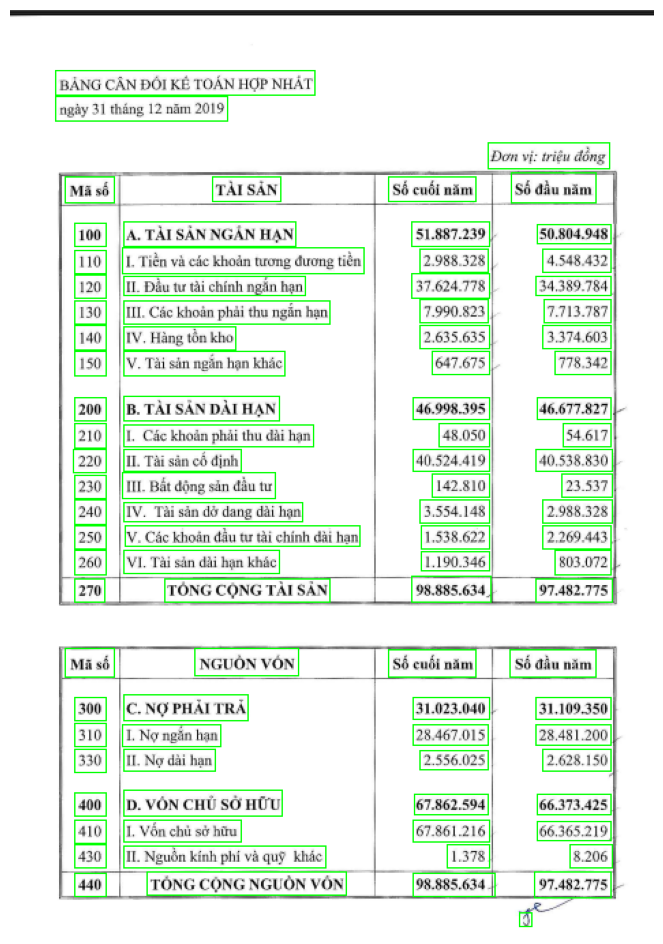

        0                                       1             2  \
0                   BẢNG CÂN ĐÓI KẾ TOÁN HỢP NHẲT                 
1                        ngảy 31 tháng 12 nm 2019                 
2                                                                 
3   Mã si                                 TẢI SẢN   Số cuói nam   
4     100                     A. TẢI SẢN NGAN HẠN    51.887.239   
5     110    L Tien vẳ các khoản [ưung đuơng tiền      2988 328   
6     120            IL Dau tư tâi chính ngan han   37..624.778   
7     130        [II, Cac khoun phảỉ thu ngẳn hụn     7.990.823   
8     140                        IV. Hàng ton kho     2.635.635   
9     150                 V.Tài san ngản han khác       647.675   
10    200                       B. TÀI SẢV DÀlHẠN    46.998.395   
11    210           1 Các khoan phudi thu dai han        48.050   
12    220                     IL. Tài sán cò djnh    40.524.419   
13    230                III  Bất dạng san diu tư       142.81

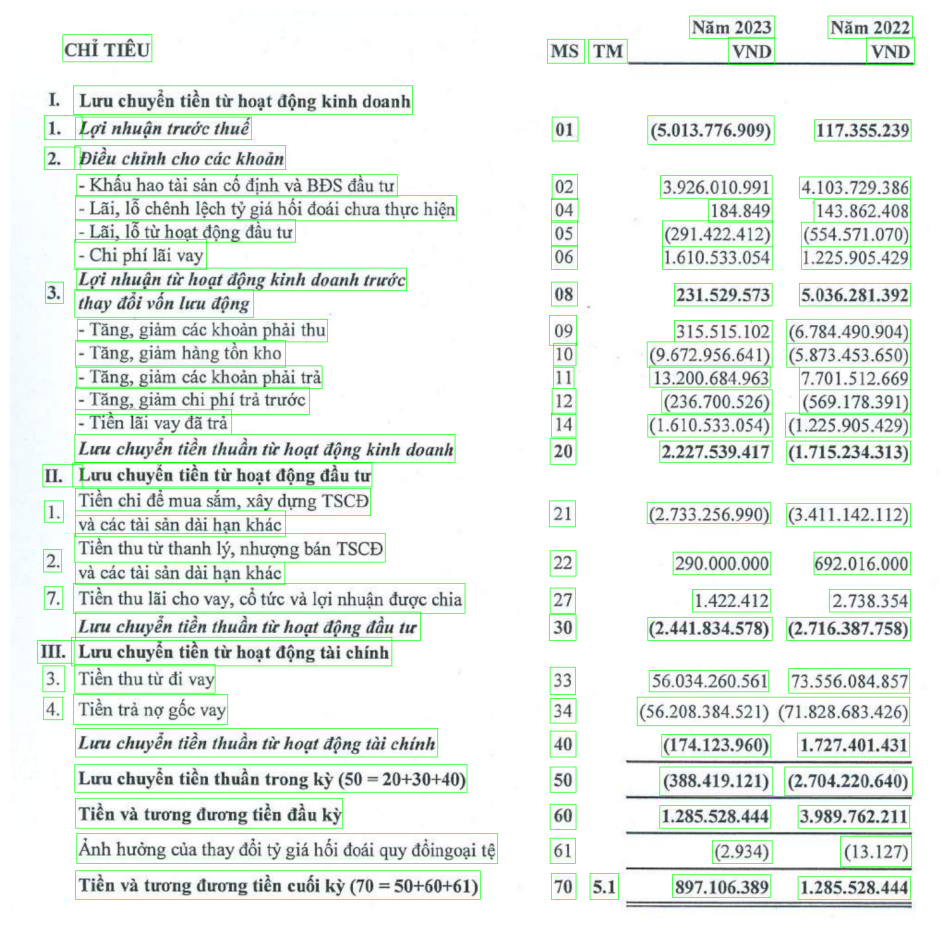

                                                    0   1    2  \
0                                                                
1                                            CHỈ TIÊU  MS   TM   
2             Lưu chuyển tiền từ hoạt động kinh doanh            
3                           1. ) Lợi nhuận trước thuế  01        
4                         2. Điều chinh cho các khoản            
5             -Khấu hao tài sản cố định và BĐS đầu tư  02        
6   -Lãi, lỗ chênh lệch tỷ giá hối đoái chua thực ...  04        
7                        -Lãi, lỗ từ hoạt động đầu tư  05        
8                                    -Chi phí lãi vay  06        
9             Lợi nhuận từ hoat động kinh doanh trước            
10                                                 3.  08        
11                              thay đổi vốn lưu động            
12                     -Tăng, giàm các khoàn phải thu  09        
13                           -Tăng, giảm hàng tồn kho  10        
14        

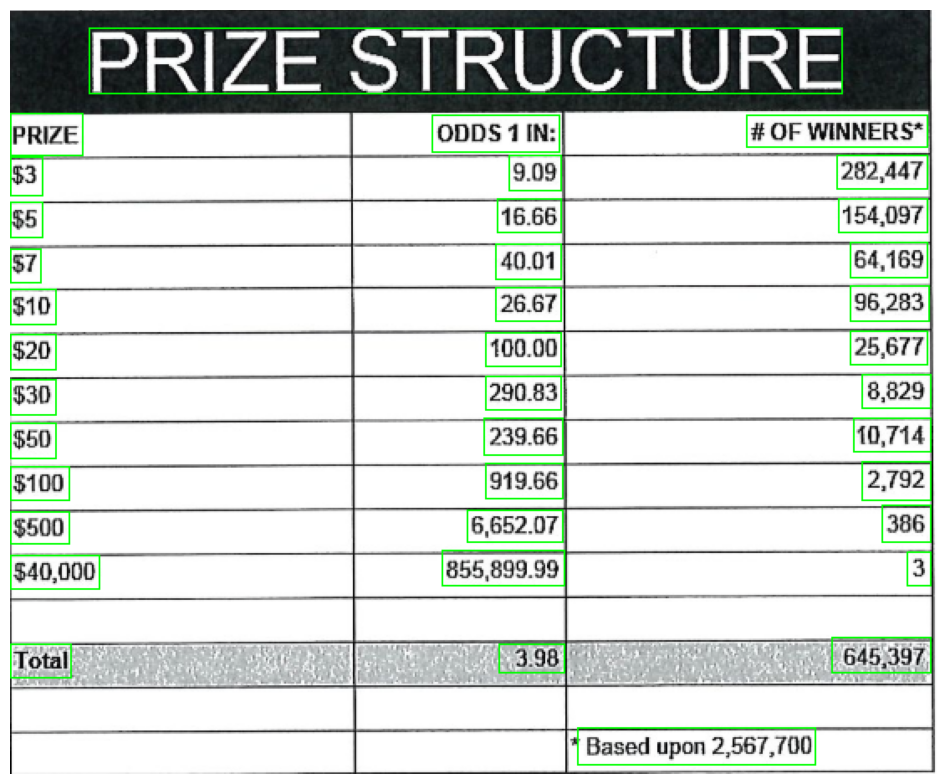

          0                1             2
0            PRIZE STRUCTURE              
1     PRIZE       ODDS 1 IN:  #OF WINNERS*
2        53             9.09       282.447
3        55            16.66       154.097
4        57            40.01        64.169
5       510            26.67        96.283
6       520           100.00        25.677
7       530           290.83         8.829
8       550           239.66        10.714
9      5100           919.66         2.792
10     550o         6.652.07           386
11  540.000       855.899.99             3
12   [Total            /3.98       645.397
13                                        
[2025/04/17 16:24:29] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


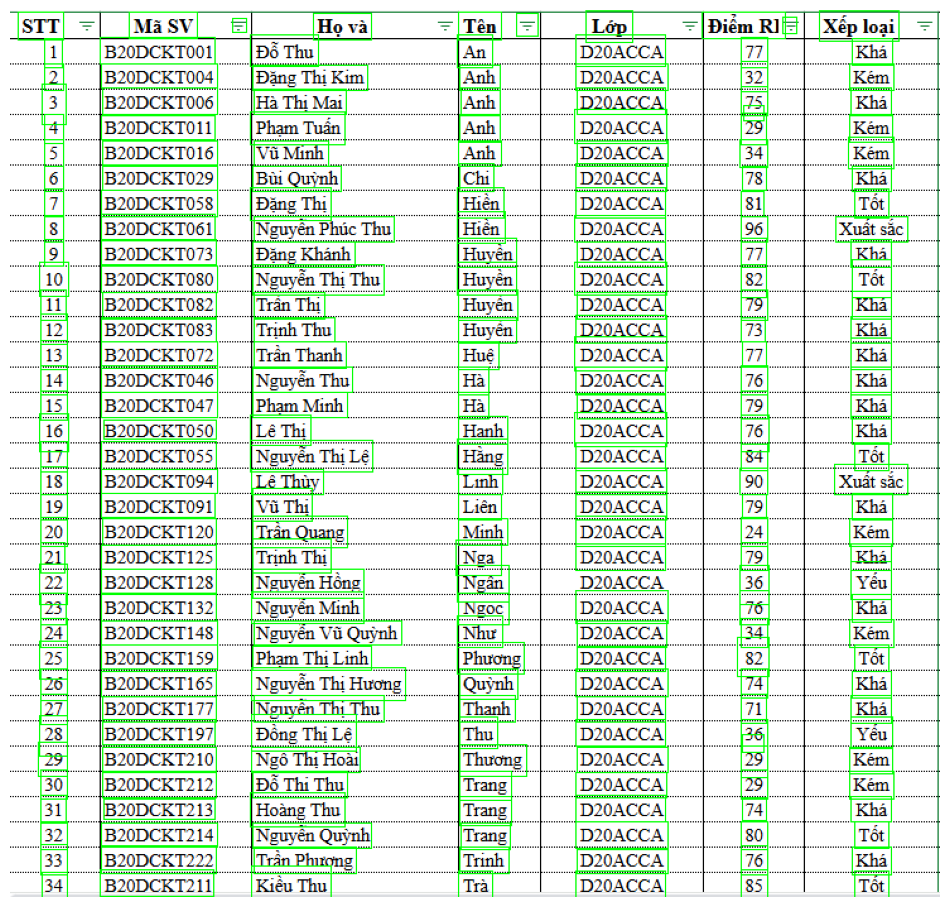

      0           1   2                3      4  5        6         7  8  \
0   STI       Mã SV  =5             Họvà   [Tên  =      LớP  [Điểm RI  =   
1     1  BZODCKTOOI                           @     D2oAcCA         1      
2     2  BZODCKTOO4                         Anh     DZOACCA        22      
3     Z  BZODCKTO06                         Anh     DZOACCA       7 =      
4     2  BZODCKTO11                           2       22222        22      
5     5  BZODCKIO16                         Anh     DZOACCA        24      
6     6  BZODCKIO29                          Th      D20ACC        78      
7     7  BZODCKTO58                          [@       22029        81      
8     8  BZODCKTO6I      Nguyễn Phúc Thu      E     DZOACCA        96      
9     9  B2ODCKTO73                        [uze     DZOACCA        77      
10    1  BZODCKTOSO                22S22    E2S          21        22      
11   11  BZODCKIDS2                          @S     DZOACCA        22      
12   12  BZO

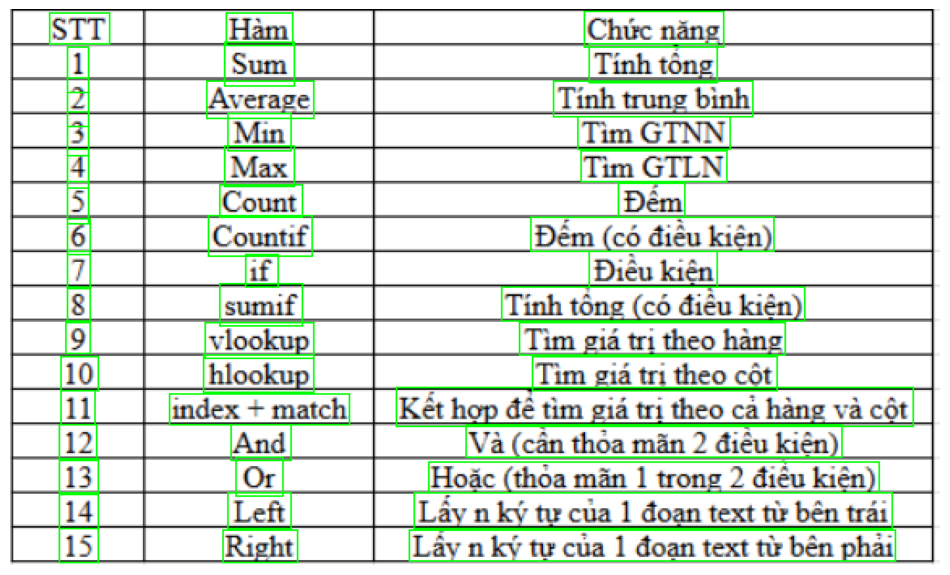

      0              1                                       2
0   STT             Hà                               Chúc nang
1     1            Sum                               Iính tong
2     2        Average                         Iinh trung binh
3     2             Mi                               Iimm GINN
4     4            Max                                Tim GILN
5     5          Count                                     Đém
6     6        Countif                      Đém (có điêu kiên)
7     7             if                                ĐÊu kiên
8     8          sumif                Iinh tông (có điêu kien)
9     9        slookup                   Tim zia tri theo hang
10   10        hlookup                    Iim giá tri theo côt
11   1l  index _ match       KẾhop đhim ghtitheo c hàng _à côt
12   12            And           Và (can thoa mãn 2 điêu kiên)
13   13             Or     Hoác (thoa màn 1 trong 2 đieu kiên)
14   11           Left     Lavpký t cua ] đoan text tù 

In [4]:
for img in os.listdir('image_test'): 
    path = os.path.join('image_test', img)
    a = tool.process_single_image(img_path= path, draw= True)
    df = pd.DataFrame(a)
    # Save CSV file 
    df.to_excel(f'out_{img}.xlsx')       
    print(df)

# For testing some idea

In [ ]:
# path = r'test.png'
class Processing:
    def __init__(self):
        self.reader = easyocr.Reader(['vi'], verbose=False)
        
    def find_rects_texts(self, img_path, mode_draw = 1):
        paddle_reader = PaddleOCR(lang='en', show_log=False)

        image = cv2.imread(img_path)
        # hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # lower_red = np.array([0, 18, 110])  # H: 169-175, S: 53-159, V: 134-255
        # upper_red = np.array([180, 255, 255])

        # # Lọc vùng đỏ trong ảnh
        # mask = cv2.inRange(hsv, lower_red, upper_red)

        # # Biến vùng đỏ thành trắng trong ảnh gốc
        # image[mask > 0] = [255, 255, 255]

        # # Làm mờ nhẹ để giảm nhiễu (Gaussian blur)
        # blurred = cv2.GaussianBlur(gray, (3, 3), 0)

        # # Tăng tương phản bằng histogram equalization
        # equalized = cv2.equalizeHist(blurred)

        # # Adaptive thresholding để phân vùng rõ chữ
        # thresh = cv2.adaptiveThreshold(
        #     equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        #     cv2.THRESH_BINARY_INV, 21, 10
        # )

        # # Loại bỏ nhiễu nhỏ bằng morphological operations
        # kernel = np.ones((1, 1), np.uint8)
        # processed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # image = processed.copy()
        img = image.copy()

        w, h = image.shape[:2]
        image = cv2.resize(image, (int(h * 2.4), int(w * 1.2)))

        # Chạy OCR để detect box
        result = paddle_reader.ocr(image, cls = True)

        result = result[0]

        boxes = [line[0] for line in result]
        rects = []
        horizontal_list = []
        texts = []


        for box in boxes:
            box = np.array(box, dtype=np.float32)
            x, y, w, h = cv2.boundingRect(box)

            # Tọa độ đã scale
            x1 = int(x / 2.4)
            y1 = int(y / 1.2)
            x2 = int((x + w) / 2.4)
            y2 = int((y + h) / 1.2)

            rects.append([x1, y1, x2, y2])
            horizontal_list.append([x1, x2, y1, y2])

        rects = np.array(rects, dtype=int)


        results = self.reader.recognize(img, horizontal_list=horizontal_list, free_list=[])


        for box, text, confidence in results:
            chars = list(text)  # Tách text thành danh sách ký tự
            for i in range(1, len(chars)):
                if chars[i] == '1' and chars[i - 1] == 'I':
                    chars[i] = 'I'
            text = ''.join(chars)
            if text == '1.':
                text = 'I.'
            elif text == '11.':
                text = 'II.'
            texts.append(text)
        if mode_draw:
            for rect in rects:
                x1, y1, x2, y2 = rect
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            plt.figure(figsize=(12, 12))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
        # rect in rects is [x1, y1, x2, y2]
        return rects, texts
    def check_line(sefl, box1, box2):
        if abs((box1[1] + box1[3]) // 2 - (box2[1] + box2[3]) // 2) < 10:
            return True
        return False

    def rects_texts_ncollum_processed(self, rects, texts):
        rects_new = []
        txts_new = []

        current_rect = []
        current_txt = []

        max_collum= 0

        for i in range(len(texts)):
            texts[i] = texts[i].strip()
            if(texts[i] == ''):
                continue

            if texts[i][0].isdigit() and texts[i][-1].isdigit():
                texts[i] = texts[i].replace(',', '.')

            if len(current_rect) == 0:
                current_rect.append(rects[i])
                current_txt.append(texts[i])
            else:
                if self.check_line(current_rect[-1], rects[i]):
                    current_rect.append(rects[i])
                    current_txt.append(texts[i])
                    
                    # print(current_txt)
                else:
                    for x in range(len(current_rect)):
                        for y in range(x + 1, len(current_rect)):
                            x_cen_x = (current_rect[x][0] + current_rect[x][2]) // 2
                            x_cen_y = (current_rect[y][0] + current_rect[y][2]) // 2
                            
                            if x_cen_x > x_cen_y:
                                current_rect[x], current_rect[y] = current_rect[y], current_rect[x]
                                current_txt[x], current_txt[y] = current_txt[y], current_txt[x] 
                    current_rect = np.array(current_rect)
                    rects_new.append(current_rect)
                    txts_new.append(current_txt)
                    
                    max_collum = max(max_collum, len(current_txt))
                    
                    
                    current_rect = [rects[i]]
                    current_txt = [texts[i]]
                    
        if len(current_rect) > 0:
            for x in range(len(current_rect)):
                for y in range(x + 1, len(current_rect)):
                    x_cen_x = (current_rect[x][0] + current_rect[x][2]) // 2
                    x_cen_y = (current_rect[y][0] + current_rect[y][2]) // 2
                    
                    if x_cen_x > x_cen_y:
                        current_rect[x], current_rect[y] = current_rect[y], current_rect[x]
                        current_txt[x], current_txt[y] = current_txt[y], current_txt[x]

            current_rect = np.array(current_rect)
        
            rects_new.append(current_rect)
            txts_new.append(current_txt)
            
            max_collum = max(max_collum, len(current_txt))

            # rects_new = np.array(rects_new)
        return rects_new, txts_new, max_collum

    def find_text_each_row(self, box_cols, list_rects, list_texts):
        array_text_reconstructed = []
        n_cols = len(box_cols)
        
        # each row
        for id_rects in range(len(list_rects)):
            array_text_cur = [' '] * n_cols
            
            # each box in row
            for id_rect in range(len(list_rects[id_rects])):
                x1, y1, x2, y2 = list_rects[id_rects][id_rect]
                x_cen = (x1 + x2) // 2

                for id_cols in range(n_cols):
                    x_min_box_col, x_max_box_col = box_cols[id_cols]
        
                    if x_cen >= x_min_box_col and x_cen <= x_max_box_col:
                        if array_text_cur[id_cols] == ' ':
                            array_text_cur[id_cols] = list_texts[id_rects][id_rect]
                        else:
                            array_text_cur[id_cols] += ' ' + list_texts[id_rects][id_rect]
                
            array_text_reconstructed.append(array_text_cur)

        return array_text_reconstructed
    def find_box_cols(self, rects_box, n_cols):
        col_box_xmin_xmax = []
        for row in rects_box:
            if len(row) == n_cols:
                col_box_xmin_xmax.append(row[:, [True, False, True, False]].flatten())
        col_box_xmin_xmax = np.array(col_box_xmin_xmax)

        row_arg_min = np.argmin(col_box_xmin_xmax, axis= 0)
        row_arg_max = np.argmax(col_box_xmin_xmax, axis= 0)

        cols_index = np.arange(col_box_xmin_xmax.shape[1])
        
        # print(col_box_xmin_xmax)
        
        x_min_each_cols = np.expand_dims(col_box_xmin_xmax[row_arg_min, cols_index][::2], axis= 0).T
        x_max_each_cols = np.expand_dims(col_box_xmin_xmax[row_arg_max, cols_index][1:][::2], axis= 0).T

        return np.concatenate([x_min_each_cols, x_max_each_cols], axis= 1)

    def processing(self, img_path, mode_draw = 0):
        rects, texts = self.find_rects_texts(img_path= img_path, mode_draw= mode_draw)
        rects_restructed, texts_restructed, n_cols = self.rects_texts_ncollum_processed(rects= rects, texts= texts)
        box_xmin_xmax_each_col = self.find_box_cols(rects_box= rects_restructed, n_cols= n_cols)
        array_texts_restructed = self.find_text_each_row(box_cols= box_xmin_xmax_each_col, list_rects= rects_restructed, list_texts= texts_restructed)
        return array_texts_restructed

In [2]:
from paddleocr import PaddleOCR
model = PaddleOCR(lang='en', show_log=False,use_gpu = False)
res = model.ocr(img= r'G:\Table Extraction from Images to CSV Excel\image_test\10.png', rec= False)


[2025/04/17 15:40:55] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


In [ ]:
res[0]

[[505.0, 638.0], [559.0, 638.0], [559.0, 658.0], [505.0, 658.0]]

In [10]:
tool = Processing()

In [16]:
path = r'G:\vietnamese-ocr\test\9.png'

[2025/04/15 03:21:08] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


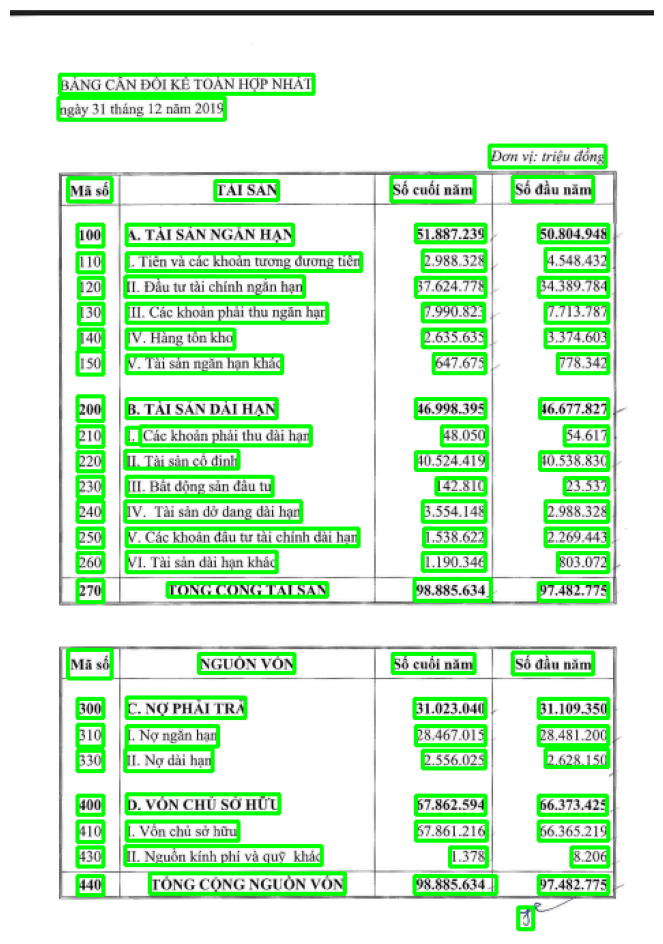

In [17]:
a = tool.processing(img_path= path, mode_draw= 1)

In [18]:
pd.DataFrame(a)

0  1                                     2             3           4
0                      BANG CÂN ĐÔIKÉTOÁN HỢP NH4I                          
1                        ngày 31 tháng 12 nam 2015                          
2                                                                           
3   Mã sí                                  TAI SAN                          
4     100                      A. TAI SÀN NGAN HẠN    51.887.239  50.804.948
5     110     [ Tién và các khodn lưong duong tien     2.988 328   4.548.432
6     120             IL Dau 1ư tài chính ngan han    37.624.776  34.389.784
7     [30         [IL, Cac khoun phaỉ thu ngun hụn     7.990.82-   7.713.787
8     140                         [V. Hàng ton khu     2.635.635   3.374.603
9     150                  V.Tai san ngán han khac       647.675     778.342
10    200                        B. TÀI SẢN DÀlHẠN    46.998.395  46.677.827
11    210  1           Cac khoun phuai thu dai han        48.050      54.617
12    220                      IL. Tai San cỦ dinh    40.524.419  10.538 830
13    230                  IIL Bẳt dong san dau lu       142.810      23.537
14    240              IV. Tai sân dở dang dai han     3.554.148   2.988.528
15    250     V Cac khoan diu tu tai chinh dai hạr     1.538.622    2.269443
16    260                 VI. Tài san dai hun khúc     1.190.346     803.072
17    270                           ToyCCovGTAisa(    98.885.634  97.482.775
18  Mã sỗ                                NGUỎN VON                          
19    300                             C.NỢ PHẴl TR    31.023.(M6  31.109.350
20    310                            1 No ngan han    28.467 0[5  28.481.200
21    330                           IL, Nợ dàỉ hạn     2.556.025    2628.150
22    400                       D. VMN CHÚ SỞ IIỮU    67.862.594  66.373.425
23    410                         1 von chu sử hữu    67.861.216  66.365.219
24    430            IL Nzuon kinh phi và qus khác         1.378      8..206
25    440                     TONG CQNG; NGUÒN VON  98.885.634 |  97.482.775
26

In [ ]:
import numpy as np
a = np.array([[1, 2, 3],
              [2, 3, 4]])
a = a * np.array([10, 20, 30])
a

array([[ 10,  40,  90],
       [ 20,  60, 120]])